# Image Classification
Classifying images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using convolutional neural network.  The dataset consists of airplanes, dogs, cats, and other objects. The images need to be normalized and the labels need to be one-hot encoded.

## Load Data

In [ ]:

from os.path import isdir

import tarfile
import helper

cifar10_dataset_folder_path = 'cifar-10-batches-py'


if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

## Explore the Data

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 2
sample_id = 100
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess images
### Normalize

In [ ]:
#ignore this cell
x = np.arange(5)
x=np.true_divide(x, 4)
x

In [ ]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x.astype('float')
    x[:,:,:,0] = np.true_divide(x[:,:,:,0],np.max(x[:,:,:,0]))
    x[:,:,:,1] = np.true_divide(x[:,:,:,1],np.max(x[:,:,:,1]))
    x[:,:,:,2] = np.true_divide(x[:,:,:,2],np.max(x[:,:,:,2]))
    return x


In [ ]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    encoded = np.zeros((len(x),10))
    encoded[np.arange(len(x)),x]=1
    return encoded

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [ ]:

# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [1]:

import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

In [ ]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32,[None,image_shape[0],image_shape[1],image_shape[2]],name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32,[None,n_classes],name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32,name="keep_prob")


In [ ]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    input_depth = x_tensor.get_shape().as_list()[-1]
    out_depth = conv_num_outputs
    shape = [conv_ksize[0],conv_ksize[1],input_depth,out_depth]
    stride_shape = [1, conv_strides[0], conv_strides[1], 1]
    pool_k = [1,pool_ksize[0],pool_ksize[1],1]
    pool_stride = [1,pool_strides[0],pool_strides[1],1]
    
    W = tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=0.1))
    b = tf.Variable(tf.truncated_normal([out_depth], mean=0.0, stddev=0.1))
    
    x_tensor = tf.nn.conv2d(x_tensor, W, strides=stride_shape, padding='SAME')
    x_tensor = tf.nn.bias_add(x_tensor, b)   
    
    x_tensor = tf.nn.max_pool(x_tensor, ksize=pool_k, strides=pool_stride,padding='SAME')
    
    return x_tensor 


### Flatten Layer

In [ ]:
from operator import mul
from functools import reduce
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    image_size = reduce(mul,x_tensor.get_shape().as_list()[1:],1)
    return tf.reshape(x_tensor,[-1,image_size])
    



### Fully-Connected Layer

In [ ]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = [x_tensor.get_shape().as_list()[-1],num_outputs]
    w = tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=0.1))
    b = tf.Variable(tf.truncated_normal([num_outputs], mean=0.0, stddev=0.1))
    y = tf.add(tf.matmul(x_tensor, w), b)
    return y



### Output Layer

In [ ]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = [x_tensor.get_shape().as_list()[-1],num_outputs]
    w = tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=0.1))
    b = tf.Variable(tf.truncated_normal([num_outputs], mean=0.0, stddev=0.1))
    y = tf.add(tf.matmul(x_tensor, w), b)
    return y


### Create Convolutional Model

In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    x = conv2d_maxpool(x, 40, (3,3), (2,2), (2,2), (2,2))
    x = conv2d_maxpool(x, 80, (3,3), (2,2), (2,2), (2,2))


    x=flatten(x)


    x=fully_conn(x, 1500)
    x=tf.nn.dropout(x, keep_prob)
    x=fully_conn(x, 250)
    x=tf.nn.dropout(x, keep_prob)
 
    x=output(x, 10)
    

    return x



tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Train the Neural Network

In [ ]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer,feed_dict={keep_prob:keep_probability, x:feature_batch, y:label_batch})


### Show Stats

In [9]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict = {x: feature_batch,y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy,feed_dict = {x: valid_features, y: valid_labels, keep_prob: 1.0})
    print("cost is: ",loss," accuracy is: ",accuracy)
    

In [10]:
# Tune Parameters
epochs = 15
batch_size = 512
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch

In [11]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost is:  2.03727  accuracy is:  0.3324
Epoch  2, CIFAR-10 Batch 1:  cost is:  1.83919  accuracy is:  0.3962
Epoch  3, CIFAR-10 Batch 1:  cost is:  1.69496  accuracy is:  0.4302
Epoch  4, CIFAR-10 Batch 1:  cost is:  1.60769  accuracy is:  0.4446
Epoch  5, CIFAR-10 Batch 1:  cost is:  1.525  accuracy is:  0.4602
Epoch  6, CIFAR-10 Batch 1:  cost is:  1.4583  accuracy is:  0.4708
Epoch  7, CIFAR-10 Batch 1:  cost is:  1.4025  accuracy is:  0.4848
Epoch  8, CIFAR-10 Batch 1:  cost is:  1.34928  accuracy is:  0.4844
Epoch  9, CIFAR-10 Batch 1:  cost is:  1.30103  accuracy is:  0.5042
Epoch 10, CIFAR-10 Batch 1:  cost is:  1.25534  accuracy is:  0.5066
Epoch 11, CIFAR-10 Batch 1:  cost is:  1.22601  accuracy is:  0.503
Epoch 12, CIFAR-10 Batch 1:  cost is:  1.20614  accuracy is:  0.502
Epoch 13, CIFAR-10 Batch 1:  cost is:  1.15259  accuracy is:  0.512
Epoch 14, CIFAR-10 Batch 1:  cost is:  1.09971  accuracy is:  0.525

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [12]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost is:  2.00226  accuracy is:  0.334
Epoch  1, CIFAR-10 Batch 2:  cost is:  1.70694  accuracy is:  0.3806
Epoch  1, CIFAR-10 Batch 3:  cost is:  1.59101  accuracy is:  0.4082
Epoch  1, CIFAR-10 Batch 4:  cost is:  1.5353  accuracy is:  0.4306
Epoch  1, CIFAR-10 Batch 5:  cost is:  1.63917  accuracy is:  0.4426
Epoch  2, CIFAR-10 Batch 1:  cost is:  1.66488  accuracy is:  0.4648
Epoch  2, CIFAR-10 Batch 2:  cost is:  1.45058  accuracy is:  0.4744
Epoch  2, CIFAR-10 Batch 3:  cost is:  1.4096  accuracy is:  0.4616
Epoch  2, CIFAR-10 Batch 4:  cost is:  1.35522  accuracy is:  0.4796
Epoch  2, CIFAR-10 Batch 5:  cost is:  1.48704  accuracy is:  0.5052
Epoch  3, CIFAR-10 Batch 1:  cost is:  1.52918  accuracy is:  0.5026
Epoch  3, CIFAR-10 Batch 2:  cost is:  1.33493  accuracy is:  0.494
Epoch  3, CIFAR-10 Batch 3:  cost is:  1.28373  accuracy is:  0.5104
Epoch  3, CIFAR-10 Batch 4:  cost is:  1.2359  accuracy is:  0.5188
Epoch  3, CIFAR-10 Batch 5:


## Test Model

Testing Accuracy: 0.6043830424547195



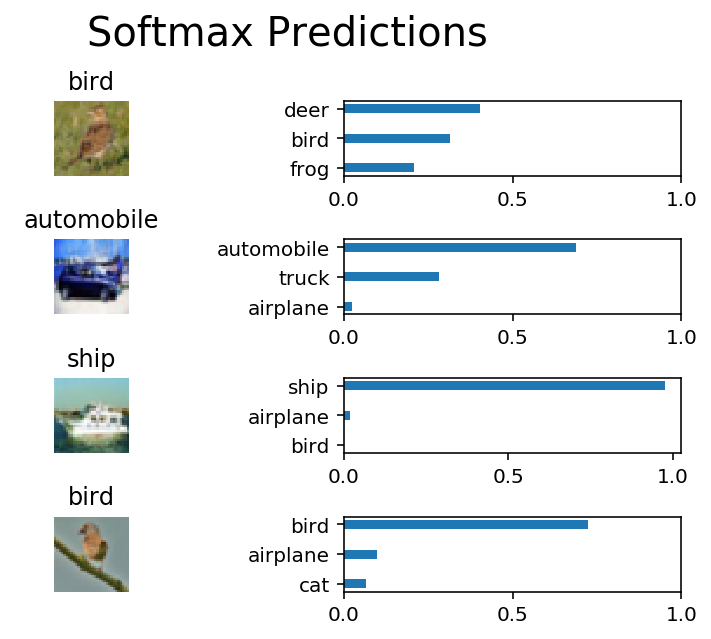

In [13]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

